# Clustering U.S. Air Pollution Profiles

The aim of this project is to **discover meaningful clusters of U.S. cities based on air quality trends** from EPA pollution measurements.

Key questions guiding the work:

- 🌍 **Regional Signatures:** Do cities in similar parts of the country share comparable air quality patterns?
- 🔬 **Pollutant Mix:** Which pollutants (O₃, CO, SO₂, NO₂) drive the separation between city groups?
- ⚠️ **Risk Profiles:** Can we surface clusters that correspond to distinct health risk levels or emission sources?
- 📈 **Actionable Insights:** What strategies might different clusters need for air-quality improvement?

---

## 📊 Methodology

1️⃣ **Data Preparation:** Clean and standardize EPA daily AQI data, then aggregate by city-state to create comparable feature vectors.

2️⃣ **Feature Scaling:** Apply StandardScaler to put pollutant averages on a common scale before clustering.

3️⃣ **Model Selection:** Evaluate KMeans across multiple k values using WCSS (elbow method) and silhouette scores to pick a well-separated solution.

4️⃣ **Cluster Profiling:** Interpret each cluster through summary statistics and visualizations to explain what makes the groups distinct.

---

## Section 1: Data Processing

To start, we'll import the libraries and data for this project. The CSV can be found inside the ZIP file of this project, or on kaggle.com. 
- https://www.kaggle.com/datasets/guslovesmath/us-pollution-data-200-to-2022

In [61]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [62]:
# Load and prepare dataset.
pollution_df = pd.read_csv('pollution_2000_2023.csv').drop(columns=['Address', 'Unnamed: 0'])
pollution_df

,Date,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,2000-01-01,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,0.878947,2.2,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,2000-01-02,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,1.066667,2.3,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2000-01-03,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,1.762500,2.5,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,2000-01-04,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,1.829167,3.0,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,2000-01-05,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,2.700000,3.7,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665409,2023-06-26,Wyoming,Laramie,Cheyenne,0.043941,0.050,12,46,0.000000,0.0,0,0.0,0.117391,0.3,7,0.0,2.282609,4.3,6,4
665410,2023-06-27,Wyoming,Laramie,Cheyenne,0.046235,0.054,12,50,0.000000,0.0,0,0.0,0.091667,0.2,8,0.0,2.283333,5.2,6,5
665411,2023-06-28,Wyoming,Laramie,Cheyenne,0.046588,0.055,7,51,0.000000,0.0,0,0.0,0.091667,0.2,6,0.0,2.487500,4.8,19,4
665412,2023-06-29,Wyoming,Laramie,Cheyenne,0.048765,0.056,9,54,0.000000,0.0,0,0.0,0.052174,0.1,8,0.0,2.086957,4.1,8,4


### Dataset and Column Description

Data contains metrics regarding four major EPA tracked pollutants. Each of the more than 600,000 rows is a unique recording from monitoring stations across the US from 2000-2023.

**1. Station Columns:** Describes when and where each reading was captured. 
- Date, City, County, and State.

**2. Pollutants Tracked:** 
- Ozone (O3)
- Carbon Monoxide (CO)
- Sulfur Dioxide (SO2)
- Nitrogen Dioxide (NO2)

**3. Pollutant Metrics:**
- Mean: Average concentration for the day.
- 1st Max Value: Highest single-hour concentration recorded that day.
- 1st Max Hour: The hour (0–23) when that peak occurred.
- AQI (Air Quality Index): Standardized scale (0-500) that converts pollutant concentrations into health risk levels.

AQI breakpoints: 0–50 Good, 51–100 Moderate, 101–150 Unhealthy for Sensitive Groups, 151–200 Unhealthy, 201–300 Very Unhealthy, 301–500 Hazardous.

In [63]:
# Verify data types. 
pollution_df.dtypes

Date                  object
State                 object
County                object
City                  object
O3 Mean              float64
O3 1st Max Value     float64
O3 1st Max Hour        int64
O3 AQI                 int64
CO Mean              float64
CO 1st Max Value     float64
CO 1st Max Hour        int64
CO AQI               float64
SO2 Mean             float64
SO2 1st Max Value    float64
SO2 1st Max Hour       int64
SO2 AQI              float64
NO2 Mean             float64
NO2 1st Max Value    float64
NO2 1st Max Hour       int64
NO2 AQI                int64
dtype: object

O3 and NO2 AQI values are stored as int, while CO and SO2 AQI values are float values. AQI values will always be whole numbers, so we'll convert them to int for simplicity. 

Date will be converted from object to datetime to take advantage of pandas date & time capabilities. 

In [64]:
# Date to datetime.
pollution_df['Date'] = pd.to_datetime(pollution_df['Date'], errors='coerce')

# AQI to int. 
pollution_df['CO AQI'] = pd.to_numeric(pollution_df['CO AQI'], errors='coerce').astype('int64')
pollution_df['SO2 AQI'] = pd.to_numeric(pollution_df['SO2 AQI'], errors='coerce').astype('int64')

pollution_df.dtypes

Date                 datetime64[ns]
State                        object
County                       object
City                         object
O3 Mean                     float64
O3 1st Max Value            float64
O3 1st Max Hour               int64
O3 AQI                        int64
CO Mean                     float64
CO 1st Max Value            float64
CO 1st Max Hour               int64
CO AQI                        int64
SO2 Mean                    float64
SO2 1st Max Value           float64
SO2 1st Max Hour              int64
SO2 AQI                       int64
NO2 Mean                    float64
NO2 1st Max Value           float64
NO2 1st Max Hour              int64
NO2 AQI                       int64
dtype: object

Now that our data types are converted, we'll check for any null and duplicate values. 

In [65]:
# Check for null values.
print("Null:", pollution_df.isnull().values.any())

# Check for duplicates.
dup_count = pollution_df.duplicated().sum()
print("Duplicates:", dup_count)

Null: False
Duplicates: 1739


No null values, though we do have a few duplicates to drop before continuing.

In [66]:
# Drop duplicates.
pollution_df = pollution_df.drop_duplicates()
print("Duplicates:", pollution_df.duplicated().sum())

# Print remaining size. 
print("Remaining:", pollution_df.shape[0])

Duplicates: 0
Remaining: 663675


The data is free of duplicates, and we're still left with over 600,000 rows. 

Before we begin clustering with AQI values, we'll check for data issues by looking at the max value for each pollutant.

In [67]:
# AQI min, max, and mean. 
aqi_stats = pollution_df[['O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI']].describe()
aqi_stats.loc[['min', 'mean', 'max']].round(2)

,O3 AQI,CO AQI,SO2 AQI,NO2 AQI
min,0.00,0.00,0.00,0.00
mean,39.15,5.25,5.17,21.79
max,237.00,201.00,200.00,153.00


AQI ranges from 0 to 500, so these values are likely real readings of poor air quality, not data issues. 

## Section 2: Model Evaluation

In this section, we'll begin experimenting to find ideal model parameters.

We'll start by grouping recordings by their city, county & state to avoid ambiguity, calculating their mean, max, and std of AQI values across time. 

In [68]:
# Group by City, County, & State.
location_stats = pollution_df.groupby(['City', 'County', 'State']).agg({
    'O3 AQI': ['mean', 'max', 'std'],
    'CO AQI': ['mean', 'max', 'std'],
    'SO2 AQI': ['mean', 'max', 'std'],
    'NO2 AQI': ['mean', 'max', 'std']
}).reset_index()

# Flatten the index. 
location_stats.columns = [
    'City', 'County', 'State',
    'O3_Mean', 'O3_Max', 'O3_Std',
    'CO_Mean', 'CO_Max', 'CO_Std',
    'SO2_Mean', 'SO2_Max', 'SO2_Std',
    'NO2_Mean', 'NO2_Max', 'NO2_Std'
]

Next, we'll create a feature matrix using each pollutants average AQI, and apply StandardScaler.

In [69]:
# Create feature matrix.
features = ['O3_Mean', 'CO_Mean', 'SO2_Mean', 'NO2_Mean']
X_location = location_stats[features].copy() 

# Apply StandardScaler.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_location)

Before we create our clusters and commit to a model, we'll test KMeans and Agglomerative clustering across various cluster quantities, k. We'll test for the best model and cluster count (k) using:
- **Elbow method:** Plots WCSS (Within-Cluster Sum of Squares) against k and looks for the point where adding more clusters yields diminishing returns in variance reduction.
- **Silhouette score:** Measures how similar each *point* is to its own cluster versus the next closest one; higher values mean tighter, better-separated clusters.
- **Davies–Bouldin:** Captures how similar each *cluster* is to its most similar neighbor; lower values indicate tighter, better-separated clusters.
- **Calinski–Harabasz:** Expresses the ratio of between-cluster dispersion to within-cluster dispersion; higher values signal clearer, more distinct structure.

**01: Agglomerative Clustering**

In [70]:
# Agglomerative tests on various k.
k_range = range(2, 10)
agg_wcss, agg_silhouette, agg_davies, agg_calinski = [], [], [], []

for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_scaled)

    agg_silhouette.append(silhouette_score(X_scaled, labels))
    agg_davies.append(davies_bouldin_score(X_scaled, labels))
    agg_calinski.append(calinski_harabasz_score(X_scaled, labels))

    centroid_sum = 0.0
    for cluster_id in range(k):
        pts = X_scaled[labels == cluster_id]
        centroid_sum += ((pts - pts.mean(axis=0)) ** 2).sum()
    agg_wcss.append(centroid_sum)

agg_results_df = pd.DataFrame({
    'k': (k_range),
    'WCSS': agg_wcss,
    'Silhouette': agg_silhouette,
    'Davies': agg_davies,
    'Calinski': agg_calinski
})

---> *Note: agglomerative clustering does not store inertia like KMeans, so WCSS was calculated manually here.*

**02: KMeans Clustering**

In [71]:
# KMeans tests on various k.
k_range = range(2, 10)
kmeans_wcss, kmeans_silhouette, kmeans_davies, kmeans_calinski = [], [], [], []

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)

    kmeans_wcss.append(model.inertia_)
    kmeans_silhouette.append(silhouette_score(X_scaled, labels))
    kmeans_davies.append(davies_bouldin_score(X_scaled, labels))
    kmeans_calinski.append(calinski_harabasz_score(X_scaled, labels))

kmeans_results_df = pd.DataFrame({
    'k': (k_range),
    'WCSS': kmeans_wcss,
    'Silhouette': kmeans_silhouette,
    'Davies': kmeans_davies,
    'Calinski': kmeans_calinski
})

We’ve now recorded all four metrics for each k under KMeans and Ward agglomerative; next we’ll plot them side by side to pick the best model and cluster count. 

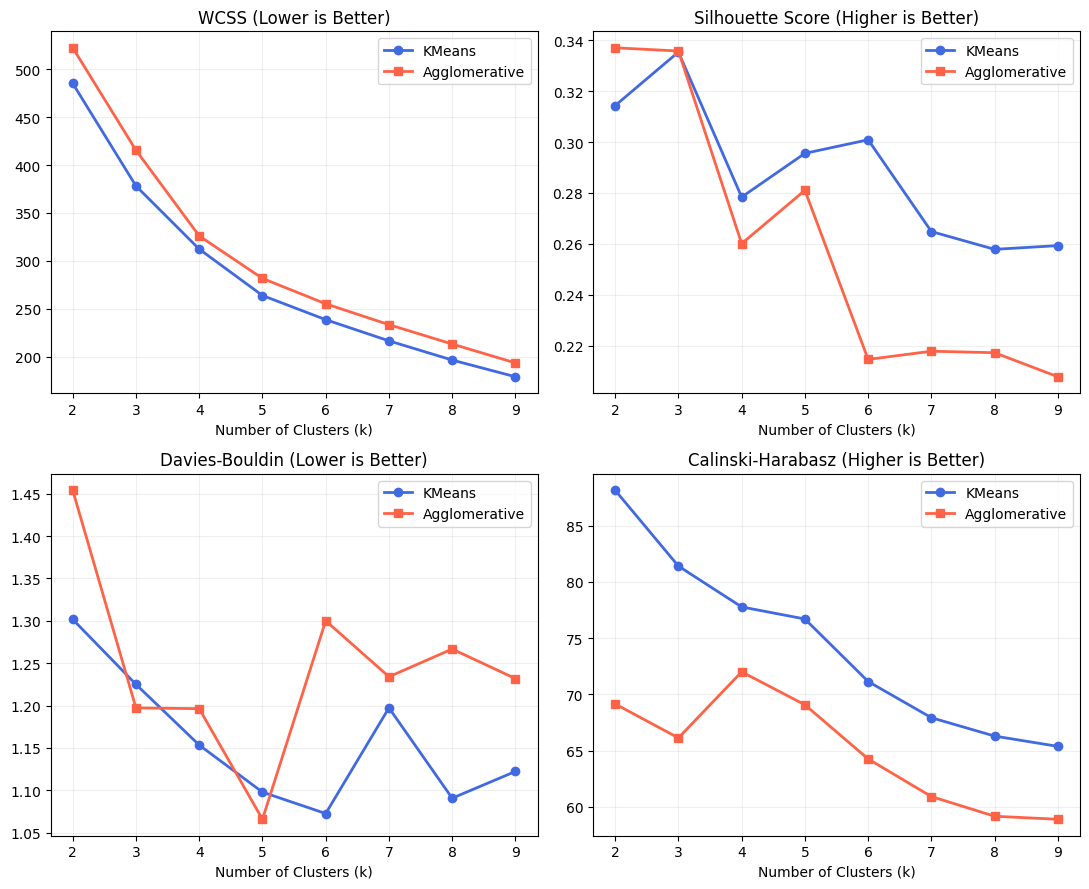

In [86]:
# Plot KMeans and Agglomerative together.
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

axes[0, 0].plot(kmeans_results_df['k'], kmeans_results_df['WCSS'], marker='o', linewidth=2, color='royalblue', label='KMeans')
axes[0, 0].plot(agg_results_df['k'], agg_results_df['WCSS'], marker='s', linewidth=2, color='tomato', label='Agglomerative')
axes[0, 0].set_title('WCSS (Lower is Better)')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].grid(alpha=0.2)
axes[0, 0].set_xticks(kmeans_results_df['k'])
axes[0, 0].legend()

axes[0, 1].plot(kmeans_results_df['k'], kmeans_results_df['Silhouette'], marker='o', linewidth=2, color='royalblue', label='KMeans')
axes[0, 1].plot(agg_results_df['k'], agg_results_df['Silhouette'], marker='s', linewidth=2, color='tomato', label='Agglomerative')
axes[0, 1].set_title('Silhouette Score (Higher is Better)')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].grid(alpha=0.2)
axes[0, 1].set_xticks(kmeans_results_df['k'])
axes[0, 1].legend()

axes[1, 0].plot(kmeans_results_df['k'], kmeans_results_df['Davies'], marker='o', linewidth=2, color='royalblue', label='KMeans')
axes[1, 0].plot(agg_results_df['k'], agg_results_df['Davies'], marker='s', linewidth=2, color='tomato', label='Agglomerative')
axes[1, 0].set_title('Davies-Bouldin (Lower is Better)')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].grid(alpha=0.2)
axes[1, 0].set_xticks(kmeans_results_df['k'])
axes[1, 0].legend()

axes[1, 1].plot(kmeans_results_df['k'], kmeans_results_df['Calinski'], marker='o', linewidth=2, color='royalblue', label='KMeans')
axes[1, 1].plot(agg_results_df['k'], agg_results_df['Calinski'], marker='s', linewidth=2, color='tomato', label='Agglomerative')
axes[1, 1].set_title('Calinski-Harabasz (Higher is Better)')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].grid(alpha=0.2)
axes[1, 1].set_xticks(kmeans_results_df['k'])
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('Output/Model_tests.png', dpi=300, bbox_inches='tight')
plt.show()

- KMeans delivers stronger scores across all four tests, particularly past k=4 with Silhouette and Davies–Bouldin peaking around k=6.
- Ward agglomerative yields its best separation at k = 2–3, but metrics deteriorate as k grows.

Because KMeans maintains better compactness and separation at the higher k values we care about, we’ll proceed with KMeans (k = 6) for the final clustering analysis.

In [73]:
# Cluster with KMeans.
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add clusters to location_stats.
location_stats['Cluster'] = cluster_labels
location_stats

,City,County,State,O3_Mean,O3_Max,O3_Std,CO_Mean,CO_Max,CO_Std,SO2_Mean,SO2_Max,SO2_Std,NO2_Mean,NO2_Max,NO2_Std,Cluster
0,Albuquerque,Bernalillo,New Mexico,45.334090,140,17.188824,3.407399,23,2.283719,0.780300,34,1.401583,22.215842,153,11.451519,5
1,Alexandria,Alexandria City,Virginia,47.696982,219,30.178470,4.990212,25,3.526884,16.020392,167,18.454759,30.955546,82,12.727059,0
2,Altoona,Blair,Pennsylvania,47.571580,203,26.552349,2.381933,13,2.056401,18.276281,104,15.467290,20.680930,86,9.766981,0
3,Annandale,Fairfax,Virginia,45.222427,218,33.282797,6.748500,20,2.491345,16.710198,105,11.364400,28.057222,73,11.111849,4
4,Arden-Arcade,Sacramento,California,44.198828,213,27.461495,6.641370,59,6.152981,2.337961,44,3.561652,18.499769,101,11.404195,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Wilkes-Barre,Luzerne,Pennsylvania,45.654189,164,22.166050,3.115865,10,2.487637,11.377897,65,9.825612,20.837790,43,7.359911,0
177,Wilmington,New Castle,Delaware,36.439232,151,18.697190,3.704839,17,2.052450,1.721832,26,2.587818,20.176210,65,9.534450,3
178,Winston-Salem,Forsyth,North Carolina,66.123711,208,38.715816,6.826804,15,1.706485,21.744330,132,21.741926,24.020619,55,9.898221,0
179,Winter Park,Orange,Florida,38.506064,174,17.159194,6.099579,53,3.155251,1.959913,82,3.999320,14.862632,109,9.901005,3


Now that we've successfully created our clusters, and cluster labels have been added to the location_stats dataframe, we can start interpreting what they mean. 

## Section 3: Cluster Analysis

First, we need to verify cluster variance to ensure we have a reasonable distribution and that each cluster has data points.

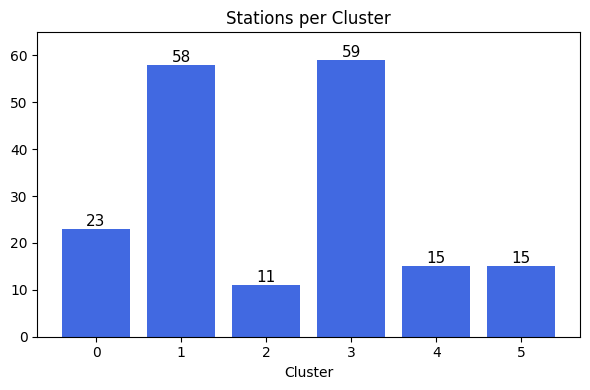

In [74]:
# Cluster variance plot.
cluster_dist = location_stats['Cluster'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(cluster_dist.index, cluster_dist.values, color='royalblue')
ax.bar_label(bars, labels=cluster_dist.values, color='black', fontsize=11)
ax.set_xlabel('Cluster')
ax.set_title('Stations per Cluster')
ax.set_ylim(0, cluster_dist.max() * 1.1)
plt.tight_layout()
plt.savefig('Output/Cluster_Variance.png', dpi=300, bbox_inches='tight')
plt.show()

- Data seems to be split into 3 parts, as clusters 1 and 3 contain 117/181 of our values, while the remaining are split among the other clusters.
- To understand what's happening, we'll average the AQI readings of each pollutant per cluster.

In [75]:
# Mean pollution per cluster.
cluster_means = location_stats.groupby('Cluster')[['O3_Mean', 'CO_Mean', 'SO2_Mean', 'NO2_Mean']].mean()
cluster_means.round(2)

,O3_Mean,CO_Mean,SO2_Mean,NO2_Mean
Cluster,,,,
0,48.51,3.47,15.39,21.93
1,37.99,2.56,1.90,10.04
2,36.51,12.06,8.01,39.78
3,35.76,5.54,5.26,23.40
4,43.99,7.40,22.90,31.46
5,55.24,5.05,2.29,18.76


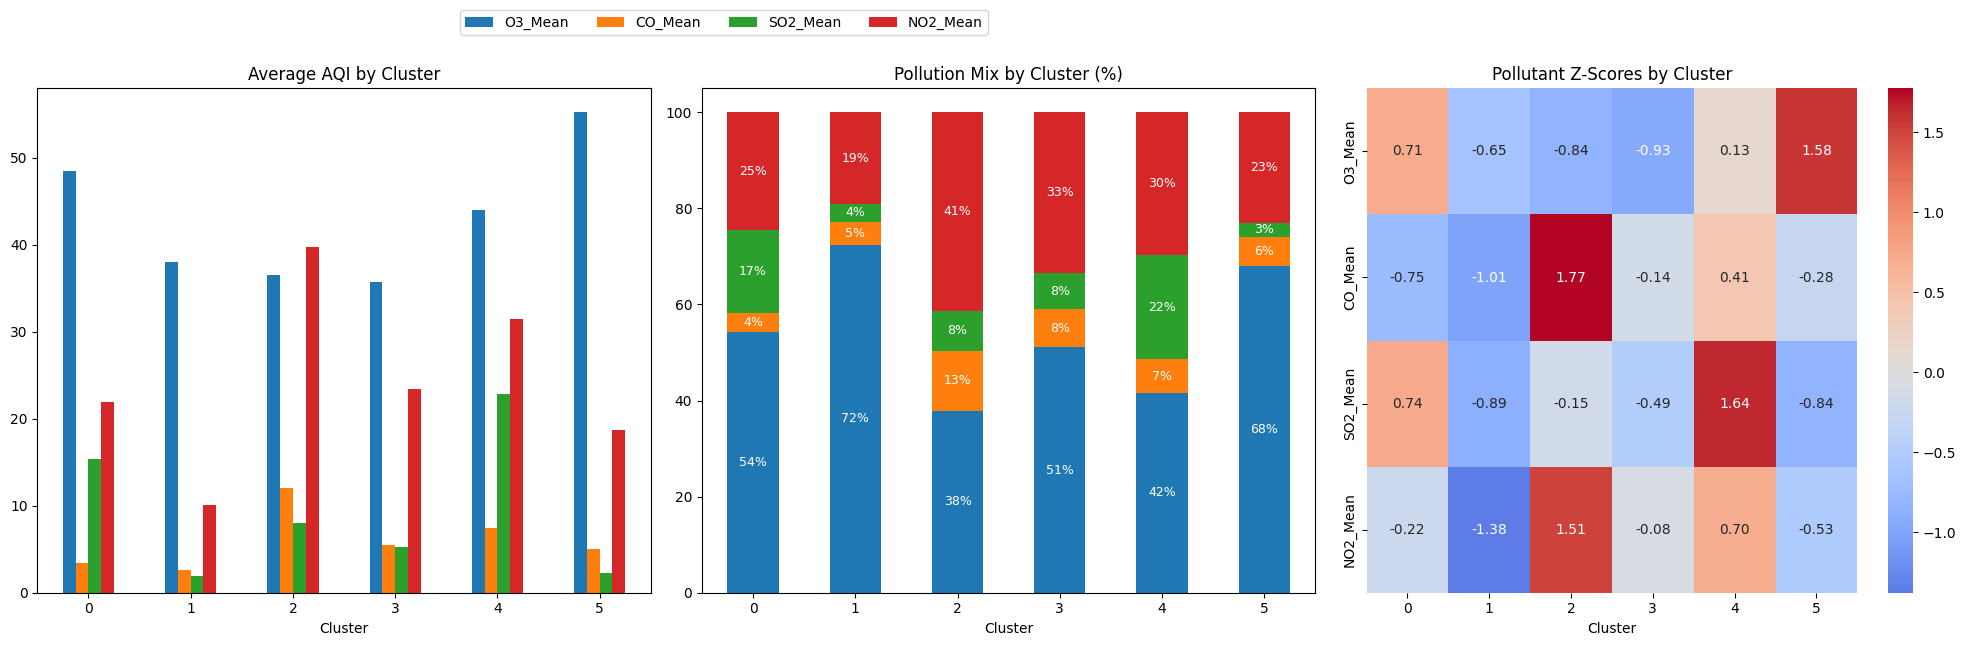

In [76]:
# Create bar charts and heatmap.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Average pollutant AQI by cluster.
cluster_means = cluster_means.astype(float)
cluster_means.plot(kind='bar', ax=axes[0], legend=False)
axes[0].set_title('Average AQI by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].tick_params(axis='x', rotation=0)

# Pollutant composition by cluster.
composition = cluster_means.div(cluster_means.sum(axis=1), axis=0) * 100
composition.plot(kind='bar', stacked=True, ax=axes[1], legend=False)
axes[1].set_title('Pollution Mix by Cluster (%)')
axes[1].set_xlabel('Cluster')
axes[1].tick_params(axis='x', rotation=0)
for bars in axes[1].containers:
    axes[1].bar_label(bars, fmt='%.0f%%', label_type='center', fontsize=9, color='white')

# Pollutant Z-score heatmap.
z_scores = ((cluster_means - cluster_means.mean()) / cluster_means.std()).astype(float)
sns.heatmap(z_scores.T, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[2])
axes[2].set_title('Pollutant Z-Scores by Cluster')
axes[2].set_xlabel('Cluster')

# Legend for bar charts.
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=len(labels), bbox_to_anchor=(0.5, 1.08))

plt.tight_layout()
plt.savefig('Output/Cluster_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

- These clusters produced surprisingly granular trends. The smaller clusters in particular contain few values but highly specific patterns and characteristics in their AQI readings. 
- This separation may reflect earlier findings from testing agglomerative clustering, which rarely yielded adequate results with more than 3 clusters.

### Analysis Summary

**00: Industrial Mix** (23 stations)
- Substantial O₃ and SO₂ readings.
- Strong sulfur signal suggests industrial activity with combined sunlight + stack emissions.

**01: Clean Baseline Areas** (58 stations)
- Lowest pollutant averages across the board.
- Smaller metros, coastal stations, and rural locations with minimal combustion and population density.

**02: Traffic Hotspots** (11 stations)
- Highest CO and NO₂ readings, far above other clusters.
- Population-dense urban centers reliant on freeway corridors where vehicle exhaust dominates air quality.

**03: Urban/Suburban Blend** (59 stations)
- Mid-range readings on all pollutants.
- Broad mix of metro and fringe areas without a single dominant emission source.

**04: Sulfur-Rich Industrial Zones** (15 stations)
- Highest SO₂ with elevated readings overall.
- Regions likely influenced by refineries, coal combustion, and/or heavy manufacturing.

**05: Ozone Hotspots** (15 stations)
- Highest O₃ with otherwise clean readings.
- Sunbelt-style environments where intense sunlight drives ozone formation.

## Section 4: Cluster Population Data

To support earlier findings or extract new patterns, I'm adding population metrics to compare with our clusters.

In [77]:
# Import county population data.
county_pop = (
    pd.read_csv('co-est2024-alldata.csv', encoding='latin1', dtype={'SUMLEV': str})
      .query('SUMLEV == "050"')
      .loc[:, ['STNAME', 'CTYNAME', 'POPESTIMATE2024']]
      .rename(columns={'STNAME': 'State', 'CTYNAME': 'County', 'POPESTIMATE2024': 'Population_2024'})
)

Since many EPA stations are not within a city, we'll start by loading county population data from the U.S. Census Bureau. The dataset can be found in the ZIP file of this project, or here: 
- https://www2.census.gov/programs-surveys/popest/datasets/2020-2024/counties/totals/

There are name discrepancies between the census and EPA data that create null values. Stripping census data of suffixes like "County" fixes most issues, though some need to be manually corrected.

In [78]:
# Manual county fixes.
county_replacements = {
    'Fairfield': 'Western Connecticut Planning Region',
    'Hartford': 'Capitol Planning Region',
    'Litchfield': 'Northwest Hills Planning Region',
    'New Haven': 'South Central Connecticut Planning Region',
    'Fairbanks North Star ': 'Fairbanks North Star'
}

# Manual state fixes.
state_replacements = {'District Of Columbia': 'District of Columbia'}

# Apply replacements.
location_stats['County'] = location_stats['County'].replace(county_replacements)
location_stats['State'] = location_stats['State'].replace(state_replacements)

In [79]:
# Replace 'Saint' with 'St.' in County names
location_stats['County'] = location_stats['County'].str.replace('Saint', 'St.', regex=False)

# Replace 'City' with 'city' in County names
location_stats['County'] = location_stats['County'].str.replace('City', 'city', regex=False)

# Strip county data names.
suffixes_to_remove = [' County', ' Parish', ' Borough', ' City']
for suffix in suffixes_to_remove:
    county_pop['County'] = county_pop['County'].str.replace(suffix, '', regex=False).str.strip()
    location_stats['County'] = location_stats['County'].str.replace(suffix, '', regex=False).str.strip()

Merging datasets on State and County, then checking for any missing population metrics or failed merges. 

In [80]:
# Merge data by State and County.
location_stats = location_stats.merge(county_pop, on=['State', 'County'], how='left')

# Dataframe with cluster population.
cl_group = location_stats.groupby('Cluster', dropna=False)['Population_2024']
cl_size = cl_group.size()
cl_no_pop = (cl_size - cl_group.count())

cluster_pop = pd.DataFrame({'Avg_Population': cl_group.mean().round(0), 'Total_Locations': cl_size, 'Missing_Count': cl_no_pop}).reset_index()
cluster_pop

,Cluster,Avg_Population,Total_Locations,Missing_Count
0,0,422340.0,23,0
1,1,592396.0,58,0
2,2,5569034.0,11,0
3,3,1336810.0,59,0
4,4,1421119.0,15,0
5,5,854171.0,15,0


No failed merges, and all values have county population data.

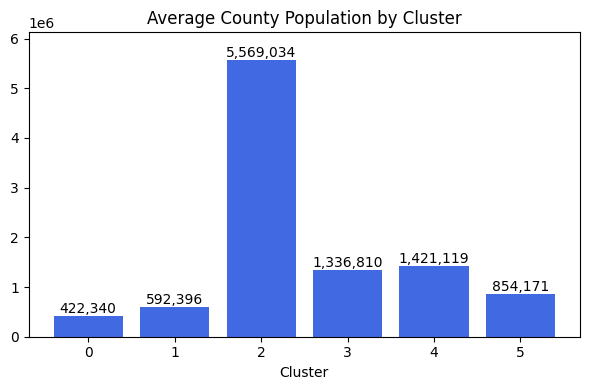

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(cluster_pop['Cluster'], cluster_pop['Avg_Population'], color='royalblue')
ax.bar_label(bars, labels=[f'{val:,.0f}' for val in cluster_pop['Avg_Population']], color='black', fontsize=10)
ax.set_title('Average County Population by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylim(0, cluster_pop['Avg_Population'].max() * 1.1)
plt.tight_layout()
plt.savefig('Output/County_Pop.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 5: Conclusion

**Nationwide signal:** Clustering 181 city–county pairs separated the data into six distinct pollution profiles:
- Industrial mix
- Very clean baseline group
- Transportation-heavy cluster
- Mixed suburban set
- SO₂-intensive industrial cohort
- Ozone-prone sunbelt segment

**Model validated:** 
- Compared with Ward agglomerative, KMeans maintained stronger Silhouette and Davies–Bouldin scores for richer solutions (k > 4), making it the most stable option for interpretation.

**Population context:** 
- Traffic-driven Cluster 2 concentrates the densest, car-centric metros, reinforcing the link between congestion and elevated NO₂/CO. 
- Industrial Cluster 4 skews toward mid-sized manufacturing hubs with high SO₂, mirroring refinery or power-plant corridors.

**Next steps:** 
- Incorporate meteorological context.
- Extend time-series analysis for temporal trends.
- Layer socio-economic and/or health outcome data.
- Map values and clusters onto a U.S. map.

**References:**
- EPA Pollution Data: https://www.kaggle.com/datasets/guslovesmath/us-pollution-data-200-to-2022
- EPA Pollutant Information: https://www.epa.gov/environmental-topics/air-topics
- County Population Data: https://www2.census.gov/programs-surveys/popest/datasets/2020-2024/counties/totals/
- Davies–Bouldin Index: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
- Calinski–Harabasz Index: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html